# Сборный проект

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. 

Имеются данные до 2016 года, данные за 2016 год могут быть неполными. Описание данных:
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

План исследования:
* **Шаг 1** - Открыть файл с данными и изучить общую информацию
* **Шаг 2** - Подготовить данные
* **Шаг 3** - Провести исследовательский анализ данных
* **Шаг 4** - Составить портрет пользователя каждого региона
* **Шаг 5** - Проверить гипотезы
* **Шаг 6** - Написать общий вывод


### Загрузка и изучение данных 

Подключаем библеотеки, считываем  и сохраняем данные.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt

In [2]:
try:
    games = pd.read_csv('C:/datasets/games.csv')
except:
    games = pd.read_csv('/datasets/games.csv')

Изучаем общую информацию.

In [3]:
games.info()
games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


***В загруженной таблице с данными 16715 строк и 11 столбцов, есть неправильно названные столбцы, столбцы с большой долей пропусков, столбцы с неверными типами данных.***

### Подготовка данных

#### Обработка пропусков 

Для начала исправляем названия столбцов.

In [4]:
games.columns = (
    ['name', 'platform', 'release_year', 'genre', 'na_sales', 'eu_sales',
     'jp_sales', 'other_sales', 'critic_score', 'user_score', 'age_rating']
)

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо! Приводим названия колонок к общепринятому стилю. 😉 <br>
А можно просто методом вот так:</font><br>
`df.columns = df.columns.str.lower()`

Метода info() достаточно чтобы оценить количество пропусков, но можно их удобнее отобразить при сочетании методов .isna() и .sum().

In [5]:
games.isna().sum()

name               2
platform           0
release_year     269
genre              2
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score    8578
user_score      6701
age_rating      6766
dtype: int64

Число пропусков в столбцах с названиями игр и с их жанрами совпало. Чтобы проверить что пропуски в одних и тех же строках, выведем их на экран. Строк, содержащих эти пропуски всего две, так что удалим их.

In [6]:
print(games[games['name'].isna()])
games = games.dropna(subset=['name'])

      name platform  release_year genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN        1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN        1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score age_rating  
659           0.08           NaN        NaN        NaN  
14244         0.00           NaN        NaN        NaN  


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, что удалили пропуски в названии игр, тем более в этих строках еще хватает пропусков по другим колонкам.</font>

Пропусков в столбце с годами выпуска игр не много, так что удалим строки с пропусками, замена на 0 или -1 усложнит работу с данными, а на медиану или среднее сильно исказит их.

In [7]:
games = games.dropna(subset=['release_year'])

В столбце с оценками критиков много пропусков, удаление всех строк с ними или замена их на какое-то значение исказит данные. Минимальная оценка данная критиками - 13, то есть отрицательных оценок нет. Чтобы пропуски не искажали данные, не мешали проводить рассчеты и проверять гипотезы, заменим их на -1, а в далнейшем просто будем игнорировать их или отсеивать при необходимости использования значений из этого столбца.

In [8]:
print(games['critic_score'].describe())
games['critic_score'] = games['critic_score'].fillna(-1)

count    7983.000000
mean       68.994363
std        13.920060
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64


В столбце с оценками пользователей много пропусков, часто встречается значение 'tbd'(to be determined), удаление всех строк с пропусками или замена их на какое-то значение исказит данные. Минимальная оценка данная пользователями - 0, то есть отрицательных оценок нет. Значение 'tbd' можно приравнять к отсутствию значения, поэтому заменим 'tbd' и пропуски на -2 по аналогичным причинам что и в столбце 'critic_score'.

In [9]:
#хотел посмотреть, часто ли попадается тбд, чтобы решить что с этим делать
frequent_user_scores = (
    games.pivot_table(index='user_score', values='name', aggfunc='count')
    .sort_values('name', ascending=False)
)
print(frequent_user_scores.head(10))

#я не могу использовать describe потому что тип данных стобца object,
#но я не могу заменять пропуски и tbd на -2, не убедившись что
#нет отрицательных оценок, поэтому заменю пока на 1000, ведь
#в описании проекта указано что макс оценка пользователей - 10.
#затем меняю тип на float
games.loc[games['user_score']=='tbd', 'user_score'] = '1000'
games['user_score'] = games['user_score'].astype(float)

#по describe понятно, что мин оценка - 0. значит можно
#менять пропуски и тбд на -2.
print(games['user_score'].describe())
games['user_score'] = games['user_score'].fillna(-2)
games.loc[games['user_score']==1000, 'user_score'] = -2

            name
user_score      
tbd         2376
7.8          322
8            285
8.2          276
8.3          252
7.5          249
8.5          247
7.9          246
8.1          237
7.7          236
count    9839.000000
mean      246.893363
std       424.959061
min         0.000000
25%         6.800000
50%         8.000000
75%         9.200000
max      1000.000000
Name: user_score, dtype: float64


В столбце с рейтингами от организации ESRB много пропусков, чтобы не удалять много строк, заменим пропуски на новую категорию RP2(Rating Pending 2).

In [10]:
print(games['age_rating'].unique())
games['age_rating'] = games['age_rating'].fillna('RP2')

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


#### Изменение типов данных

В столбцах с годами выпуска и с оценками критиков только целые числа, тип данных заменим на int.

In [11]:
#да, можно было с датой так не париться конечно, в итоге все равно инт
games['release_year'] = pd.to_datetime(games['release_year'], format='%Y').dt.year

#проверяю что нет дробных оценок
print(games['critic_score'].unique())
games['critic_score'] = games['critic_score'].astype(int)

[76. -1. 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65. 54.
 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 41. 36. 31.
 27. 35. 26. 19. 28. 23. 24. 21. 17. 13.]


#### Добавление столбца с суммой продаж по всем регионам

In [12]:
games['sum_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

Бонусом обработаем дубликаты. Авторские права не позволили бы выйти двум играм с абсолютно одинаковым названием на одной и той же платформе, еще и жанр с возрастным рейтингом совпали. От греха подальше удалим эти 8 строк, хоть и на результаты исследования это особо не повлияет.

Затем проверим результаты обработки пропусков, дубликатов и изменения типов данных.

In [13]:
print(games[games.duplicated(['name', 'platform', 'genre', 'age_rating'])])
#keep=False вместо 'first', чтобы удалить все такие строки, я же не знаю
#у какой из игр правильно указаны оценки а у какой - нет. а оценки у игры разные
games = games.drop_duplicates(subset=['name', 'platform', 'genre', 'age_rating'], keep=False)
games.head()

                              name platform  release_year   genre  na_sales  \
1591   Need for Speed: Most Wanted     X360          2005  Racing       1.0   
11715  Need for Speed: Most Wanted       PC          2012  Racing       0.0   
16230                Madden NFL 13      PS3          2012  Sports       0.0   

       eu_sales  jp_sales  other_sales  critic_score  user_score age_rating  \
1591       0.13      0.02         0.10            83         8.5          T   
11715      0.06      0.00         0.02            82         8.5          T   
16230      0.01      0.00         0.00            83         5.5          E   

       sum_sales  
1591        1.25  
11715       0.08  
16230       0.01  


,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,age_rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-2.0,RP2,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-2.0,RP2,31.38


Оценим результаты подготовки данных.

In [14]:
games.info()
games.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16438 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16438 non-null  object 
 1   platform      16438 non-null  object 
 2   release_year  16438 non-null  int64  
 3   genre         16438 non-null  object 
 4   na_sales      16438 non-null  float64
 5   eu_sales      16438 non-null  float64
 6   jp_sales      16438 non-null  float64
 7   other_sales   16438 non-null  float64
 8   critic_score  16438 non-null  int32  
 9   user_score    16438 non-null  float64
 10  age_rating    16438 non-null  object 
 11  sum_sales     16438 non-null  float64
dtypes: float64(6), int32(1), int64(1), object(4)
memory usage: 1.6+ MB


,release_year,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,sum_sales
count,16438.000000,16438.000000,16438.000000,16438.000000,16438.000000,16438.000000,16438.000000,16438.000000
mean,2006.485096,0.263881,0.145897,0.078514,0.047578,32.961735,2.139968,0.535869
std,5.875945,0.818368,0.506782,0.311154,0.188032,36.297154,4.654385,1.558949
min,1980.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-2.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-2.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,-1.000000,-2.000000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,70.000000,7.300000,0.470000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000,82.540000


***Исправлены названия столбцов; обработаны пропуски в шести стобцах, в зависимости от типа и значимости данных; изменены типы данных в двух столбцах; добавлен новый столбец с суммой продаж; даже обработаны дубликаты. В результате аккуратной подготовки данных большинство строк удалось сохранить - из 16715 осталось 16438, все пропуски устранены, все типы данных корректные.***

***Пропуски в столбцах с названием игры и с их жанрами могли быть вызваны невнимательностью сотрудника, собиравшего данные из открытых источников, не трудно случано пропустить 2 строчки.***

***Пропуски в столбце с годом выпуска игры могут быть связаны с тем, что год уже указан в столбце с названием игры; возможно игроки имели доступ к ранним версиям игры, и произошла путаница, какой год считать годом выпуска; год может быть пропущен по причине технического сбоя при загрузке данных.***

***Пропуски в столбцах с оценками пользователей и с оценками критиков могут быть по причине того, что игра вышла давно, и сложно найти ресурсы с оценкой этой игры; игра вышла недавно, либо игра непопулярна и еще не набрала достаточное количество оценок; возможно, данных нет по технической причине - например на сайтах где собирались данные по играм просто не были указаны оценки этих игр.***

***Пропуски в столбце с возрастным рейтингом возникли потому, что рейтинг ESRB предназначен для маркировки игр для США и Канады, для других регионов он не заполняется. В данном случае пропуск имеет признак, что игра выпущена не в Северо-Американском регионе.***


### Исследовательский анализ данных

#### Изучение выпущенных и проданных игр для разных платформ в разные годы

Отобразим количество выпущенных игр в разные годы на графике. 

Видно, что количество выпущенных игр можно разделить на условные периоды, например до 1995 года игр выпускалось очень мало, а в текущий период - с 2012 по 2016, выпускается сильно меньше игр чем с 2007 по 2011.

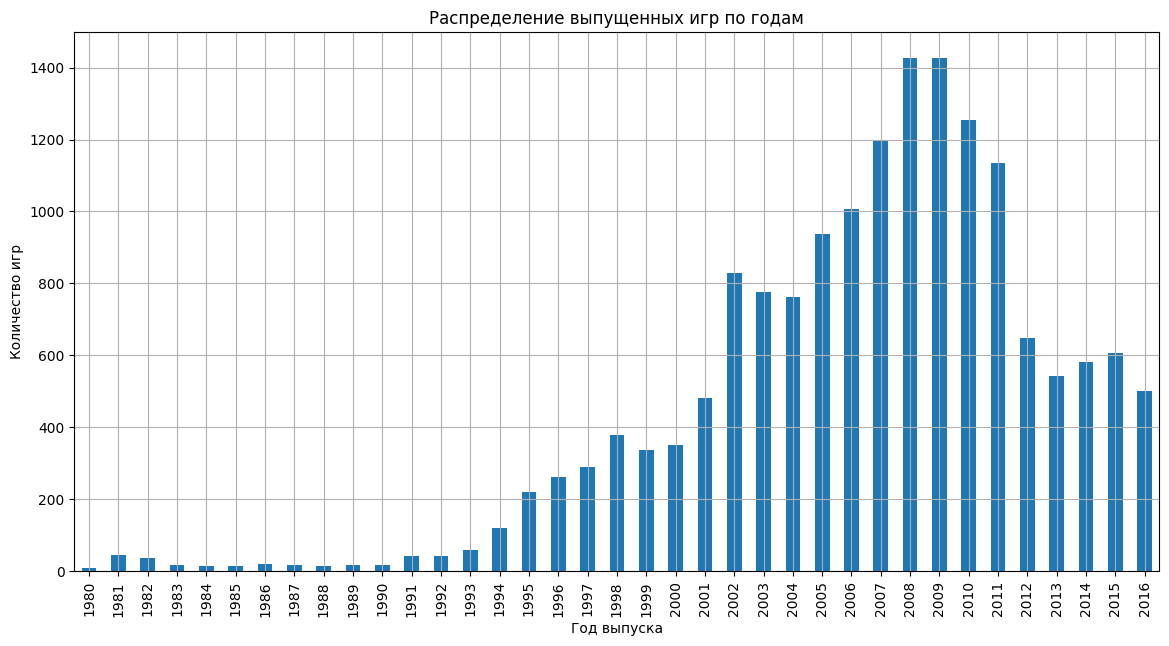

In [15]:
games_per_year = games.pivot_table(index='release_year', values='name', aggfunc='count')
games_per_year.plot(kind='bar', figsize=(14, 7), legend=False, grid=True)
plt.title('Распределение выпущенных игр по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.show()

Изучим платформы с наибольшими суммарными продажами. 

Можно выделить 6 лидирующих платформ, которые сильно отрываются по количеству проданных копий от своих конкурентов.

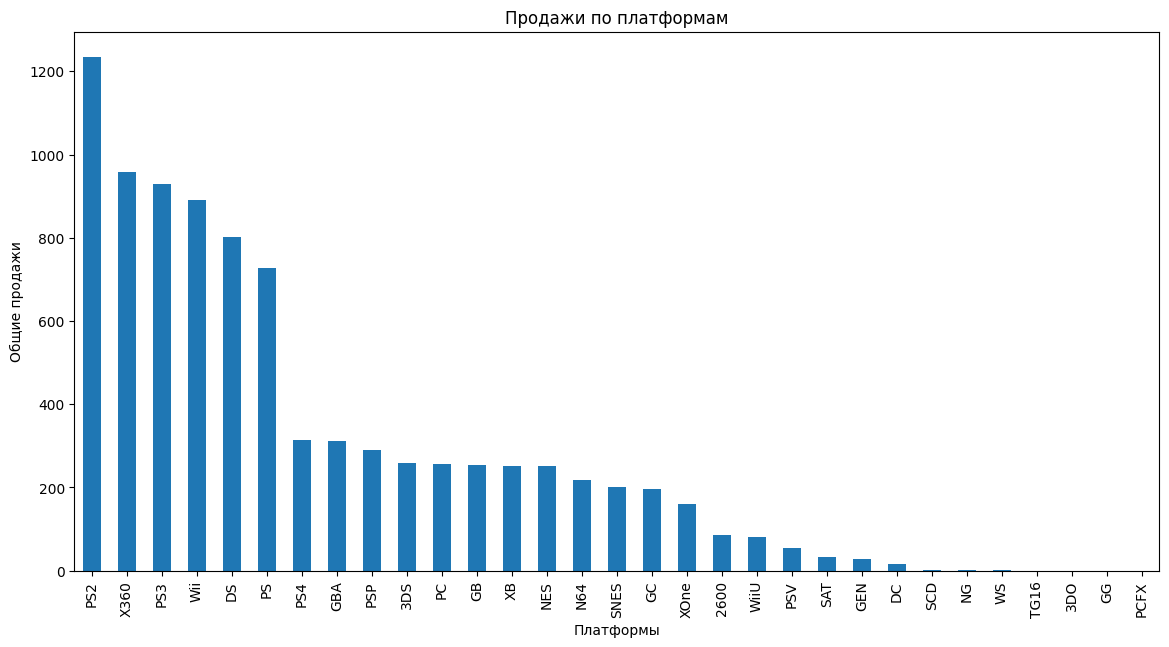

In [16]:
most_profitable_platforms = (
    games.pivot_table(index='platform', values='sum_sales', aggfunc='sum')
    .sort_values(by='sum_sales', ascending=False)
)
# most_profitable_platforms.head(10)
most_profitable_platforms.plot(kind='bar', figsize=(14, 7), legend=False)
plt.title('Продажи по платформам')
plt.xlabel('Платформы')
plt.ylabel('Общие продажи')
plt.show()

Посмотрим, как менялись продажи по платформам, для этого построим распределение по годам. Также рассчитаем срок актуальности игровой платформы, взяв данные после 1994 года.

По графику видно, что для каждой из 6 платформ с наибольшими суммарными продажами есть тенденция к уменьшению продаж игр, либо игры на эти платформы уже не продаются. Исходя из графика и рассчетов, срок актуальности игровой платформы составляет 7-10 лет.

Срок актуальности игровой платформы: 7.0 лет


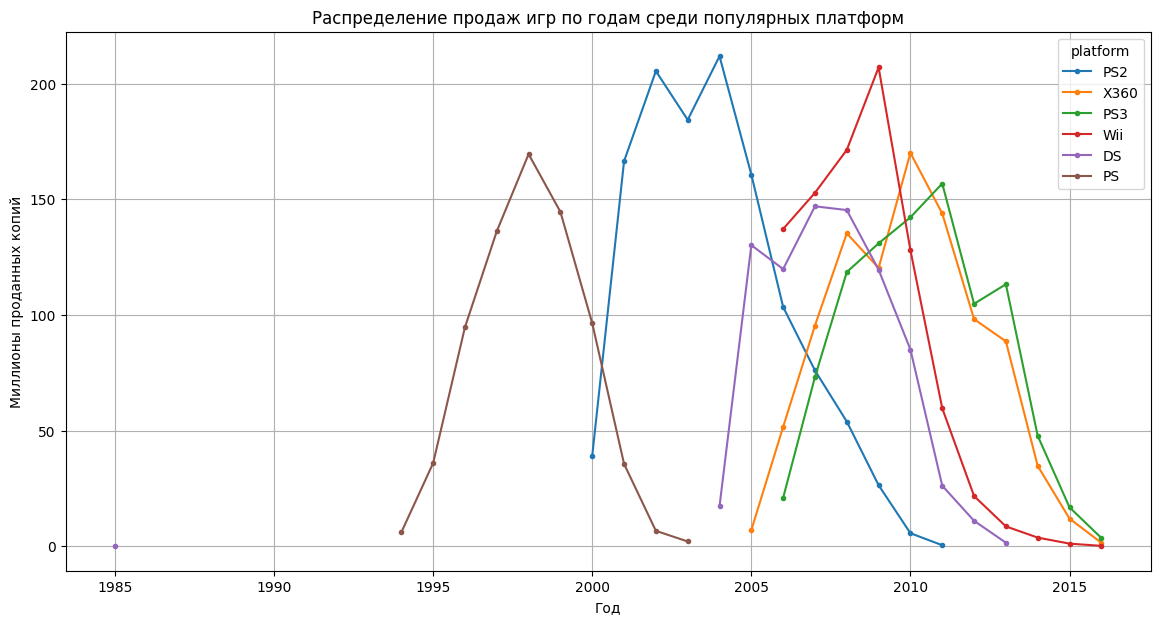

In [17]:
life_time = (
    games.query('release_year > 1994')
    .pivot_table(index='platform', values='release_year',
                 aggfunc=['min', 'max']).reset_index()
)
life_time['life'] = life_time['max'] - life_time['min'] + 1 
# в срок жизни платформы, должны входить границы диапазона, поэтому +1
print(f'Срок актуальности игровой платформы: {life_time["life"].median()} лет')


sales_platform_year = (
    games.pivot_table
    (index='release_year', columns='platform', 
     values='sum_sales', aggfunc='sum')
)

#оставляю только столбцы с платформами у которых наибольшие продажи
sales_platform_year = sales_platform_year[['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']]

sales_platform_year.plot(figsize=(14,7), grid=True, style='.-')
plt.title('Распределение продаж игр по годам среди популярных платформ')
plt.xlabel('Год')
plt.ylabel('Миллионы проданных копий')
plt.show()

На графике распределения продаж игр по годам среди популярных платформ видно, что в 1985 году было продано 20 тысяч копий игры для платформы DS, но этой платформы тогда еще не существовало. Очевидно, это ошибка, удалим строку с неверными данными.

In [18]:
print(games.query('release_year==1985 and platform=="DS"'))
print(games.shape)
games = games.query('~(release_year==1985 and platform=="DS")')
games.shape   

                                      name platform  release_year   genre  \
15957  Strongest Tokyo University Shogi DS       DS          1985  Action   

       na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
15957       0.0       0.0      0.02          0.0            -1        -2.0   

      age_rating  sum_sales  
15957        RP2       0.02  
(16438, 12)


(16437, 12)

Игровая индустрия сильно изменилась за 36 лет. Нет смысла анализировать устаревшие данные, возьмем данные только за актуальный период. На основании графика распределения выпущенных игр по годам, и исходя из стандартного срока актуальности платформы, обозначим актуальный период - 2012-2016 годы. Эти данные помогут построить прогноз на 2017 год.

In [19]:
data = games.query('release_year > 2011')
data['release_year'].unique() #остались только нужные годы

array([2013, 2015, 2012, 2014, 2016], dtype=int64)

#### Определение лидирующих по продажам  и потенциально прибыльных платформ

Выясним, какие платформы лидируют по продажам в последнее время, растут или падают, для этого построим распределение по годам.


По графику видно, что продажи игр среди всех представленных платформ падают. Относительно остальных, прибыльными все еще остаются PS4 - более 69 миллионов проданных копий игр за последние 5 лет, XOne - более 26 миллионов и 3DS - более 15 миллионов проданных копий игр.

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
release_year,,,,,,,,,,,
2016,15.14,NaN,5.25,3.6,69.25,NaN,4.25,0.18,4.6,1.52,26.15


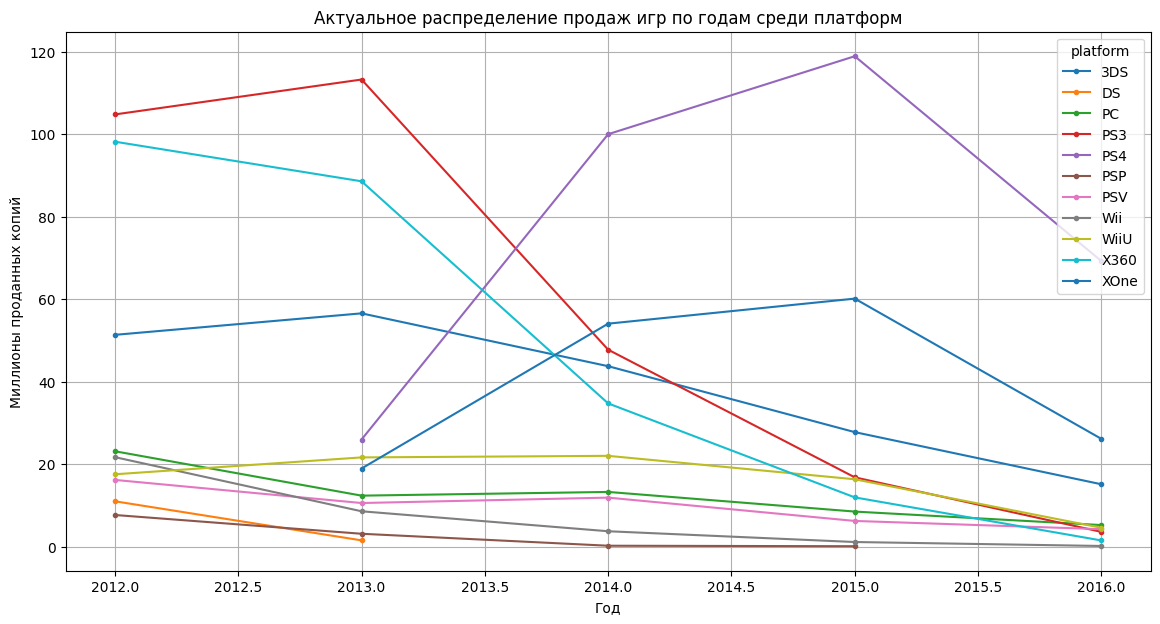

In [20]:
actual_platforms = (
    data.pivot_table
    (index='release_year', columns='platform', 
     values='sum_sales', aggfunc='sum')
)
actual_platforms.plot(figsize=(14,7), grid=True, style='.-')
plt.title('Актуальное распределение продаж игр по годам среди платформ')
plt.xlabel('Год')
plt.ylabel('Миллионы проданных копий')
actual_platforms.tail(1)

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.


По графику видно, что у каждой из платформ есть игры-хиты, сильно оторвавшиеся по продажам от остальных. Большинство же игр покупают не более 2 миллионов раз.

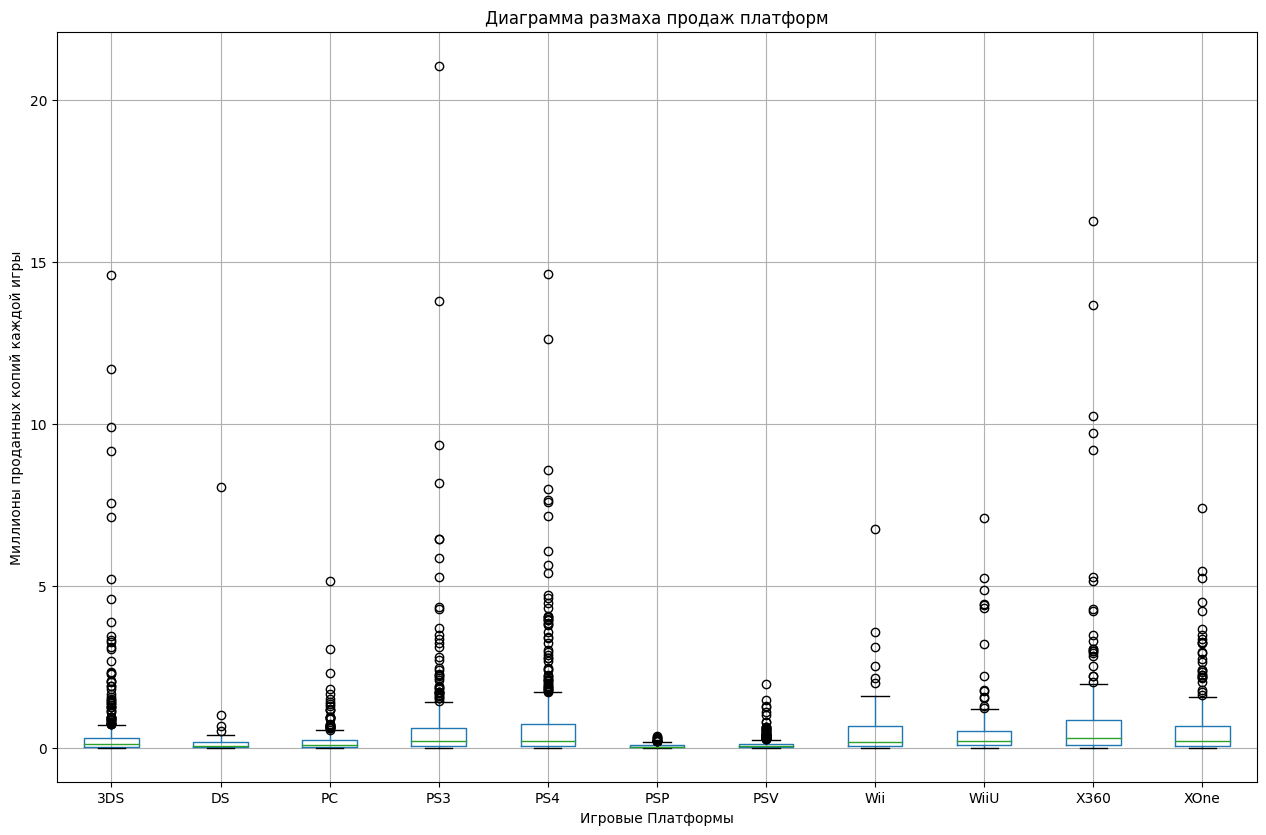

In [21]:
data.boxplot(column=['sum_sales'], by='platform', figsize=(15,10)) 
plt.suptitle('')
plt.title('Диаграмма размаха продаж платформ')
plt.xlabel('Игровые Платформы')
plt.ylabel('Миллионы проданных копий каждой игры')
plt.show()

Хоть самой прибыльной платформой за последние 5 лет и является PS4 с более чем 69 миллионами проданных копий игр, игры на XOne, X360 и WiiU немного успешнее в медиане, например у X360 более половины игр разошлись тиражом более 300 тысяч копий. Это происходит во многом потому, что на PS4 выходит больше "хитов". Об успешности PS 4, PS 3, Wii, X360 и XOne говорит высокое положение на шкале третьего квартиля(верхняя граница межквартильного размаха). Предел нормальных значений для X360 близок к 2 миллионам, в то время как для PSP он находится около 200 тысяч, то есть игры этой платформы, у которых количество проданных копий превысило это значение, можно назвать необычайно успешными для этой платформы.

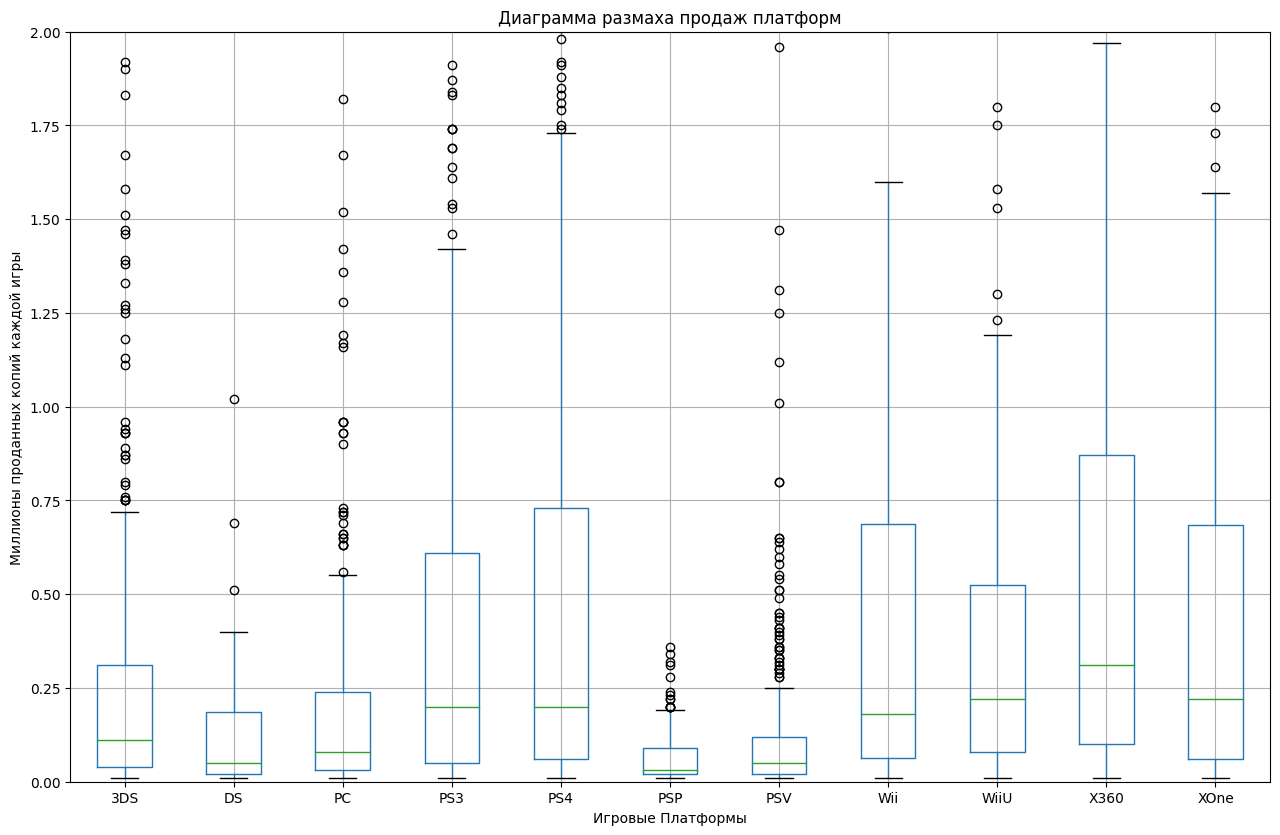

In [22]:
data.boxplot(column=['sum_sales'], by='platform', figsize=(15,10)) 
plt.suptitle('')
plt.title('Диаграмма размаха продаж платформ')
plt.xlabel('Игровые Платформы')
plt.ylabel('Миллионы проданных копий каждой игры')
plt.ylim(0, 2)
plt.show()

#### Определение влияния оценок на продажи игр среди платформ

Посмотрим, как отзывы пользователей и критиков влияют на продажи внутри PS4, для этого построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 

Как ни странно, на успешность игр на PS4 никак не влияют оценки пользователей, возможно это связано с тем особым складом ума консольщиков, о котором все говорят. Либо просто оценки пользователей необъективны. Отзывы критиков умеренно влияют на число проданных копий. 

Коэффициент корреляции между продажами и отзывами критиков: 0.4065679020617816
Коэффициент корреляции между продажами и отзывами пользователей: -0.03195711020455643


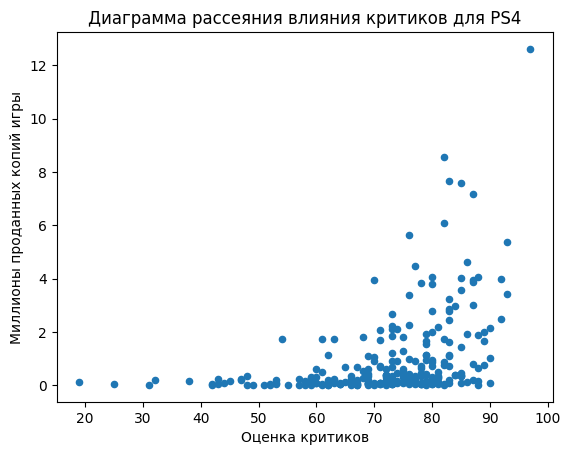

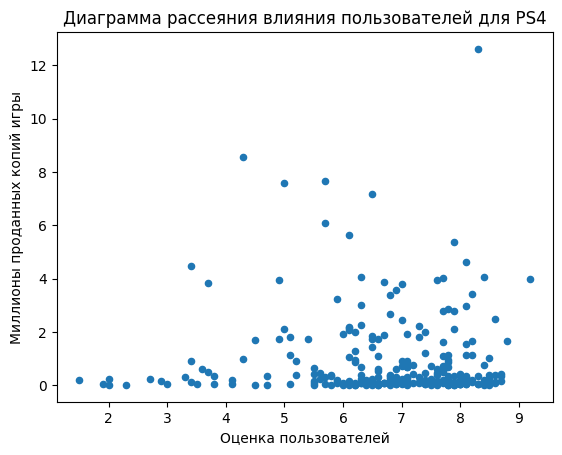

In [23]:
data.query('platform=="PS4" and critic_score!=-1').plot(kind='scatter', x = 'critic_score', y = 'sum_sales')
plt.title('Диаграмма рассеяния влияния критиков для PS4')
plt.xlabel('Оценка критиков')
plt.ylabel('Миллионы проданных копий игры')

data.query('platform=="PS4" and user_score!=-2').plot(kind='scatter', x = 'user_score', y = 'sum_sales')
plt.title('Диаграмма рассеяния влияния пользователей для PS4')
plt.xlabel('Оценка пользователей')
plt.ylabel('Миллионы проданных копий игры')

critic_corr = (
    data.query('platform == "PS4" and critic_score!=-1')['critic_score']
    .corr(data.query('platform == "PS4" and critic_score!=-1')['sum_sales'])
)
user_corr = (
    data.query('platform == "PS4" and user_score!=-2')['user_score']
    .corr(data.query('platform == "PS4" and user_score!=-2')['sum_sales'])
)
print(f'Коэффициент корреляции между продажами и отзывами критиков: {critic_corr}')
print(f'Коэффициент корреляции между продажами и отзывами пользователей: {user_corr}')

Теперь соотнесем выводы о влиянии оценок на продажу игр на PS4 с влиянием для других платформ. для этого построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 

Рассчет коэффициента корреляции для платформы 3DS
Коэффициент корреляции между продажами и отзывами критиков: 0.3208028695360785
Коэффициент корреляции между продажами и отзывами пользователей: 0.19758263411038599 

Рассчет коэффициента корреляции для платформы PC
Коэффициент корреляции между продажами и отзывами критиков: 0.23871145075973388
Коэффициент корреляции между продажами и отзывами пользователей: -0.12007943893375937 

Рассчет коэффициента корреляции для платформы PS3
Коэффициент корреляции между продажами и отзывами критиков: 0.3320585024475759
Коэффициент корреляции между продажами и отзывами пользователей: -0.004158189480245863 

Рассчет коэффициента корреляции для платформы WiiU
Коэффициент корреляции между продажами и отзывами критиков: 0.34837976012017485
Коэффициент корреляции между продажами и отзывами пользователей: 0.4002190202148617 

Рассчет коэффициента корреляции для платформы XOne
Коэффициент корреляции между продажами и отзывами критиков: 0.4169983280084017
Ко

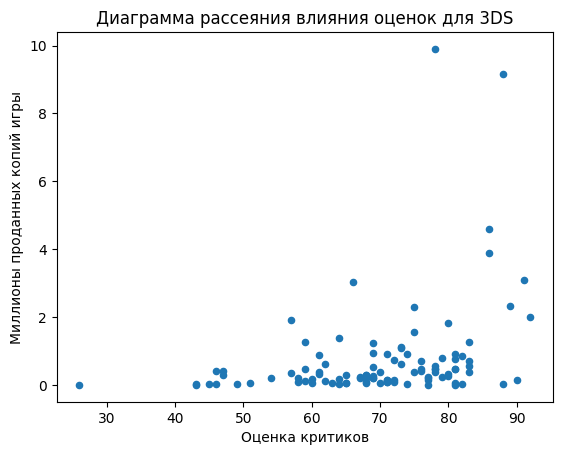

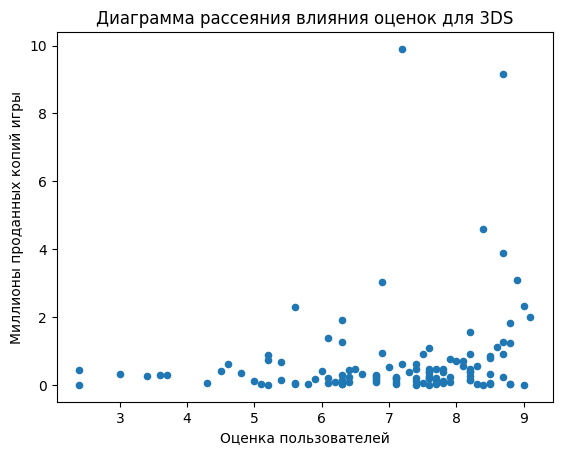

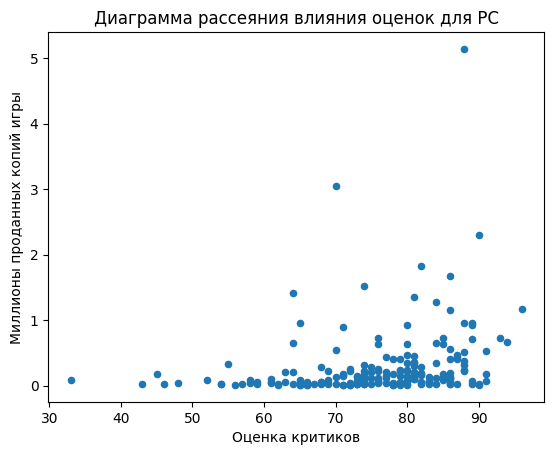

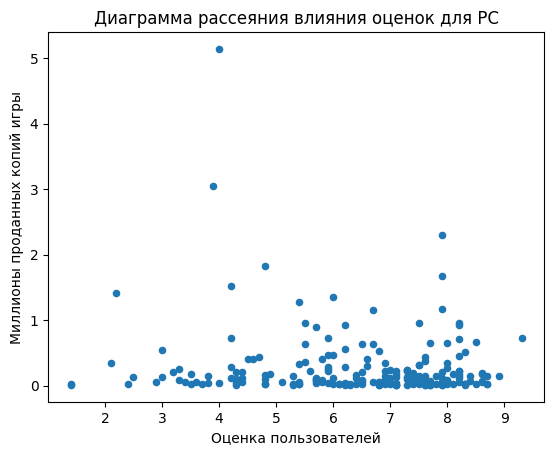

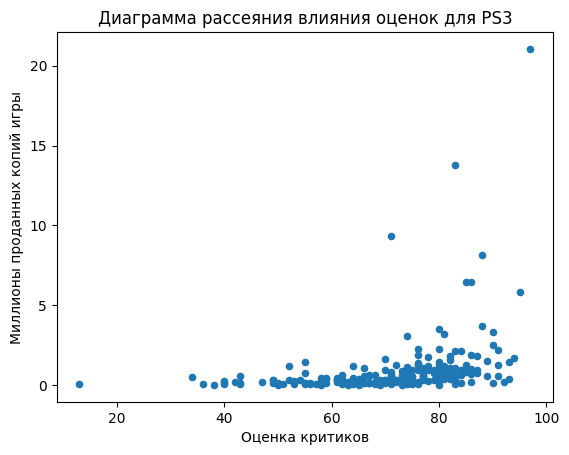

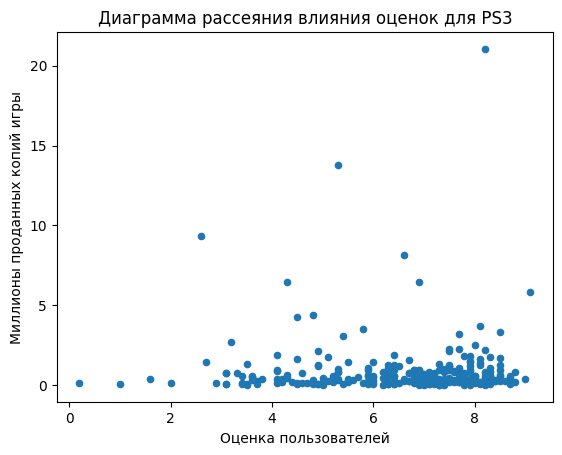

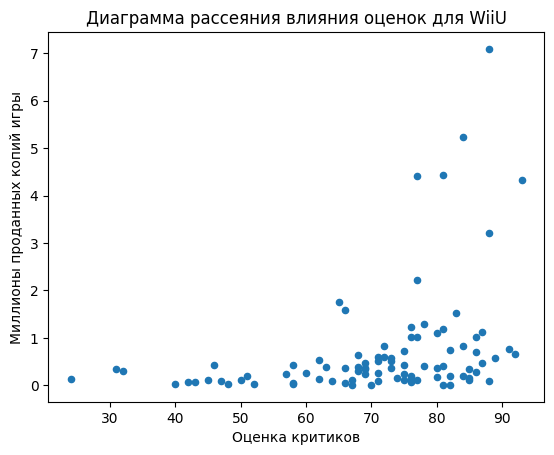

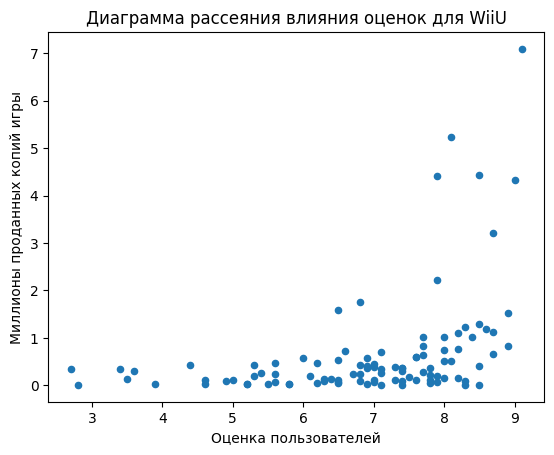

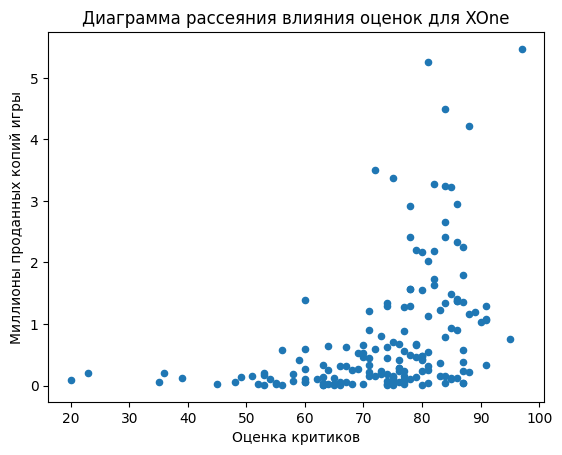

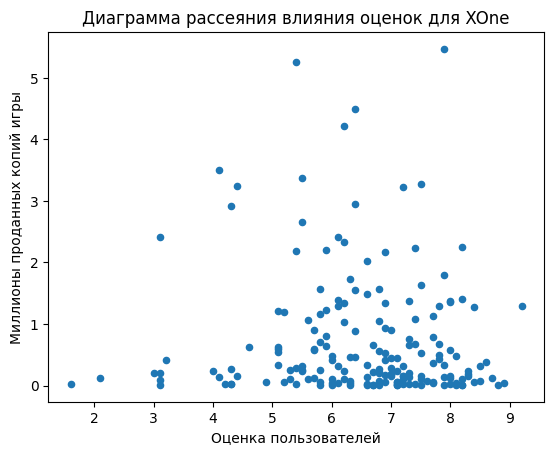

In [24]:
for pla in ["3DS", "PC", "PS3", "WiiU", "XOne"]:
    
    """
Eсли ты это читаешь, то возможно тебе нужно пояснение. 
Для каждой платформы из 5 выбранных мной переменным critic_corr и user_corr
присвивается коэф корреляции между продажами игры и ее оценкой.
Затем выводится название платформы и ее коэффициенты для пользователей и критиков.

Потом для каждой платформы и каждого вида заглушек, одна из которых есть только 
у юзеров и вторая только у критиков, строятся графики.
"""
    critic_corr = (
        data.query('platform == @pla and critic_score!=-1')['critic_score']
        .corr(data.query('platform == @pla and critic_score!=-1')['sum_sales'])
    )
    user_corr = (
        data.query('platform == @pla and user_score!=-2')['user_score']
        .corr(data.query('platform == @pla and user_score!=-2')['sum_sales'])
    )
    print(f'Рассчет коэффициента корреляции для платформы {pla}')
    print(f'Коэффициент корреляции между продажами и отзывами критиков: {critic_corr}')
    print(f'Коэффициент корреляции между продажами и отзывами пользователей: {user_corr} \n')
    for cus in [-1, -2]:  
        if cus == -1:
            sc_type = 'critic_score'
        if cus == -2:
            sc_type = 'user_score'
        data.query('platform==@pla and user_score!=@cus and critic_score!=@cus').plot(kind='scatter', x = sc_type, y = 'sum_sales')
        plt.ylabel('Миллионы проданных копий игры')
        plt.title(f'Диаграмма рассеяния влияния оценок для {pla}')
        if cus == -1:
            plt.xlabel('Оценка критиков')
        if cus == -2:
            plt.xlabel('Оценка пользователей')               

Корреляции выбранных платформ получились довольно близкими к корреляциям PS4.

Среди пяти выбранных платформ на успешность игр как правило не влияют или слабо влияют оценки пользователей, только у WiiU есть умеренная корреляция между этими параметрами - 0.40. Возможно, оценки пользователей необъективны, и игра на самом деле хороша, либо игроки, прежде чем купить игру, руководствуются рейтингом критиков, а не пользовательским рейтингом. 

Для большинства платформ отзывы критиков умеренно влияют на число проданных копий. Наименьший коэффицинт корреляции между этими параметрами среди выбранных платформ у PC - 0.24. Лишь Для WiiU корреляция между продажами и отзывами критиков ниже, чем корреляция между продажами и оценками пользователей.

#### Определение прибыльных и популярных жанров

Посмотрим на общее распределение игр по жанрам, построив столбчатую диаграмму.

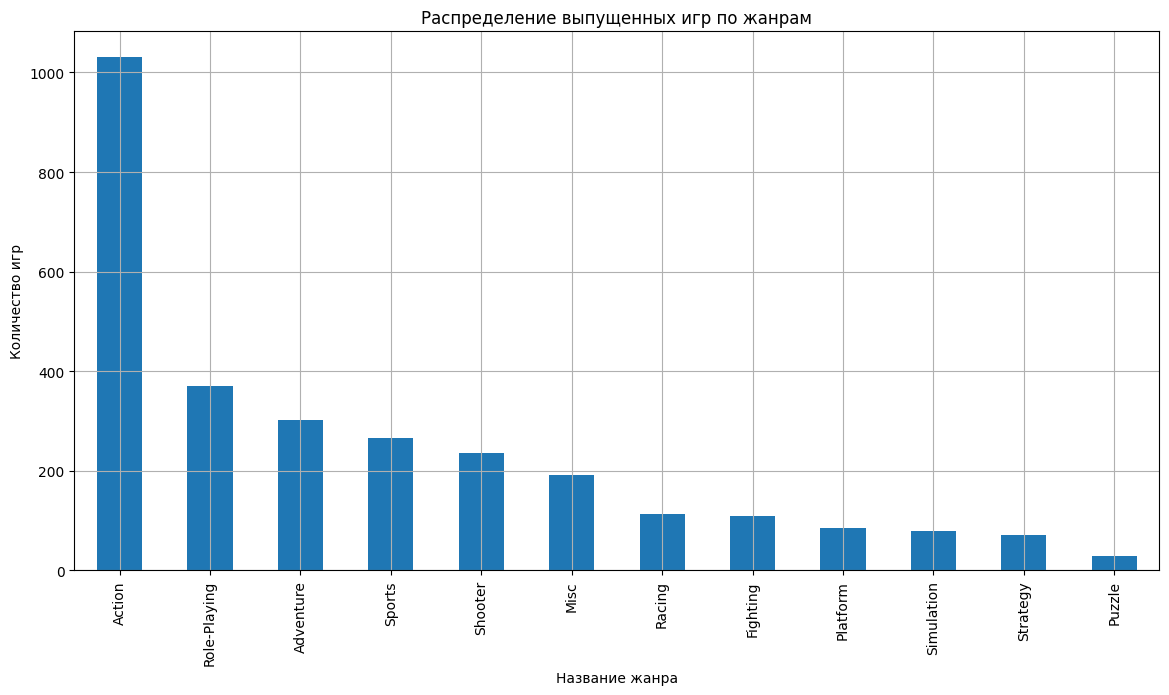

In [25]:
games_per_genre = data.pivot_table(index='genre', values='name', aggfunc='count').sort_values(by='name', ascending=False)
games_per_genre.plot(kind='bar', figsize=(14, 7), legend=False, grid=True)
plt.title('Распределение выпущенных игр по жанрам')
plt.xlabel('Название жанра')
plt.ylabel('Количество игр')
plt.show()

Определим самые популярные жанры, построив столбчатую диаграмму. 

По предыдущему графику мы видели, что в жанре action выпускается намного больше игр, чем в других - более 1000 игр за последние 5 лет. Самый непопулярный по количеству выпущенных игр жанр - puzzle. 

Этот график похож на предыдущий, но по нему видно, насколько много было продано копий игр в жанре shooter относительно того, сколько их было выпущено, и насколько мало в жанре adventure. Скорее всего это связано с тем, что в жанре adventure чаще выпускаются инди-игры, не требующие больших бюджетов и большого числа сотрудников для их создания. В жанре shooter чаще выходят triple A проекты, задана высокая планка графики и механик хитовыми играми, требуется больший бюджет и штат сотрудников для их разработки.

Жанры с высокими и низкими продажами сильно выделяются относительно медианы и среднего.

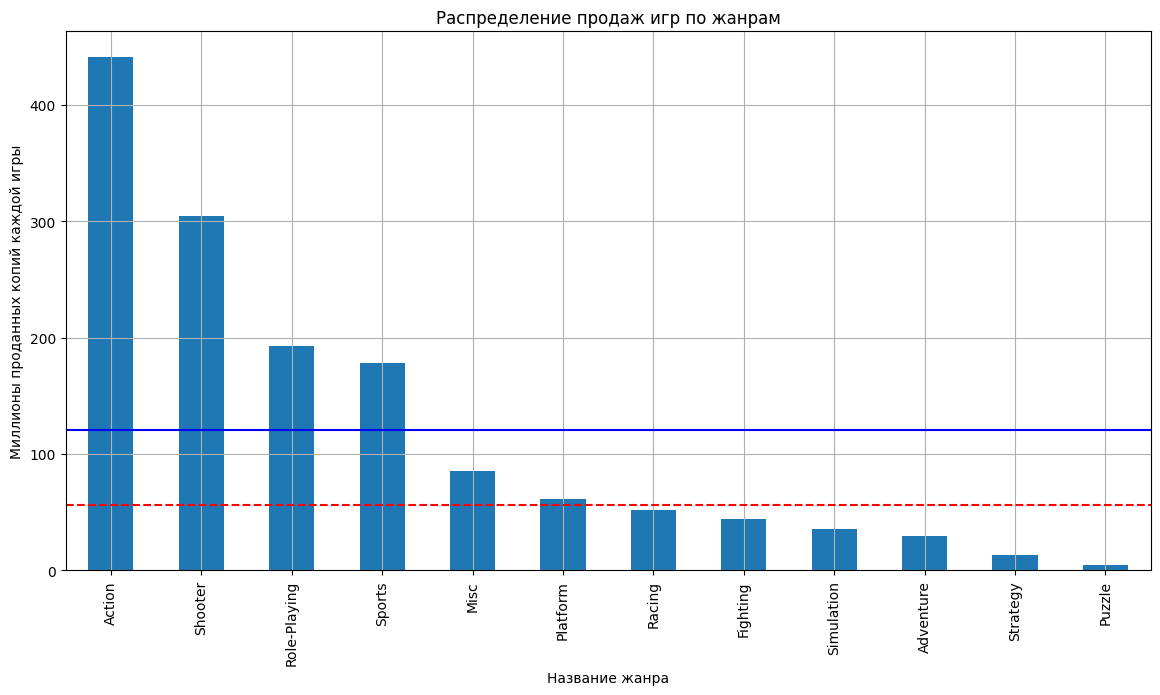

In [26]:
sales_per_genre = data.pivot_table(index='genre', values='sum_sales', aggfunc='sum').sort_values(by='sum_sales', ascending=False)
med = float(sales_per_genre['sum_sales'].median())
avg = float(sales_per_genre['sum_sales'].mean())

sales_per_genre.plot(kind='bar', figsize=(14, 7), legend=False, grid=True)
plt.title('Распределение продаж игр по жанрам')
plt.xlabel('Название жанра')
plt.ylabel('Миллионы проданных копий каждой игры')
plt.axhline(y=med, label='median', color='r', linestyle='--')
plt.axhline(y=avg, label='mean', color='b')
plt.show()

Определим стабильные жанры, который приносят доход не зависимо от платформы, для этого построим диаграмму размаха.

Хоть самым популярным жанром по суммарному количеству проданных копий и является action, медианное число проданных копий разных игр для этого жанра намного ниже, чем у platform, shooter или sports, а значит игры этого жанра реже успешно продаются. Диапазон количеств проданных копий игры, которых можно ожидать - нормальных значений - у shooter достигает 3,5 миллиона, то есть для игры жанра shooter обычное дело разойтись на 3,5 миллиона копий. Следующими по этому показателю идут sports и platform. Больше всего самых хитовых игр выходит у жанра action.


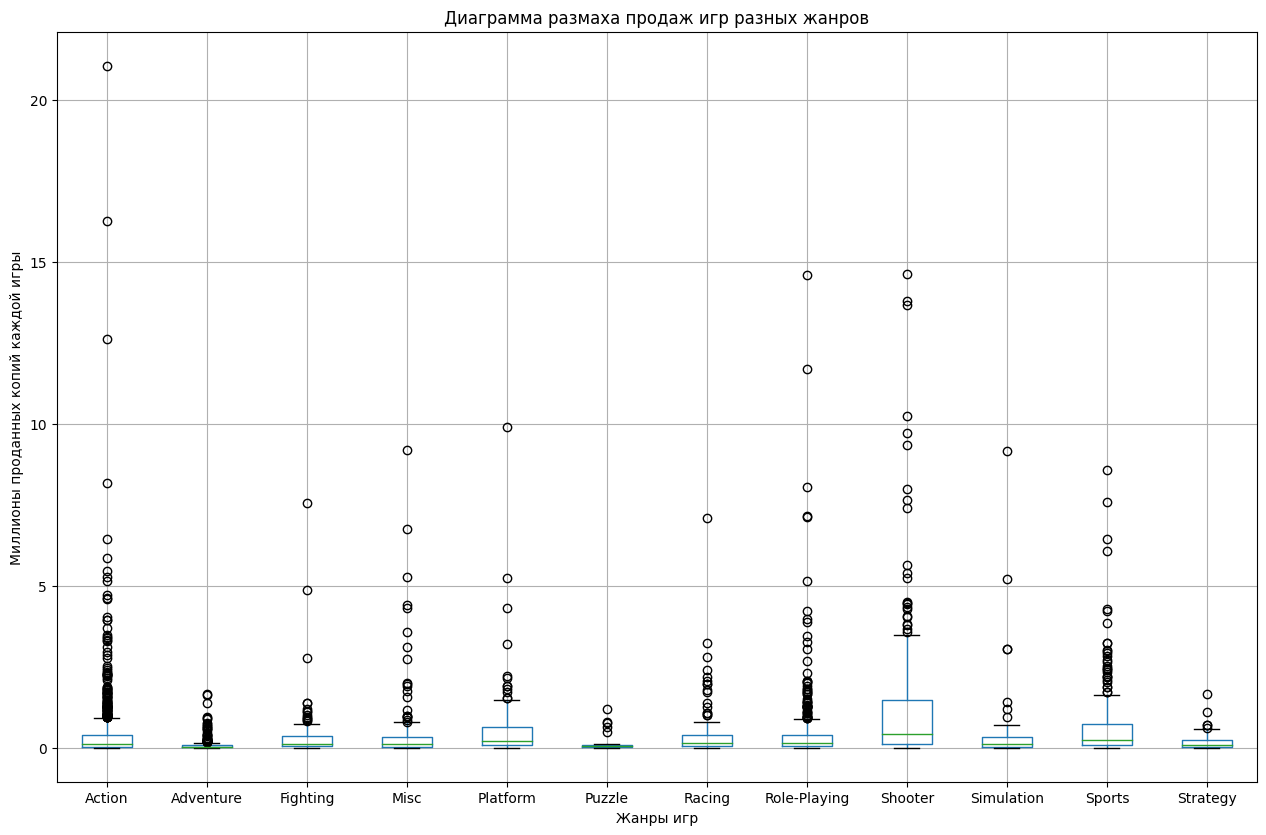

In [27]:
data.boxplot(column=['sum_sales'], by='genre', figsize=(15,10)) 
plt.suptitle('')
plt.title('Диаграмма размаха продаж игр разных жанров')
plt.xlabel('Жанры игр')
plt.ylabel('Миллионы проданных копий каждой игры')
plt.show()

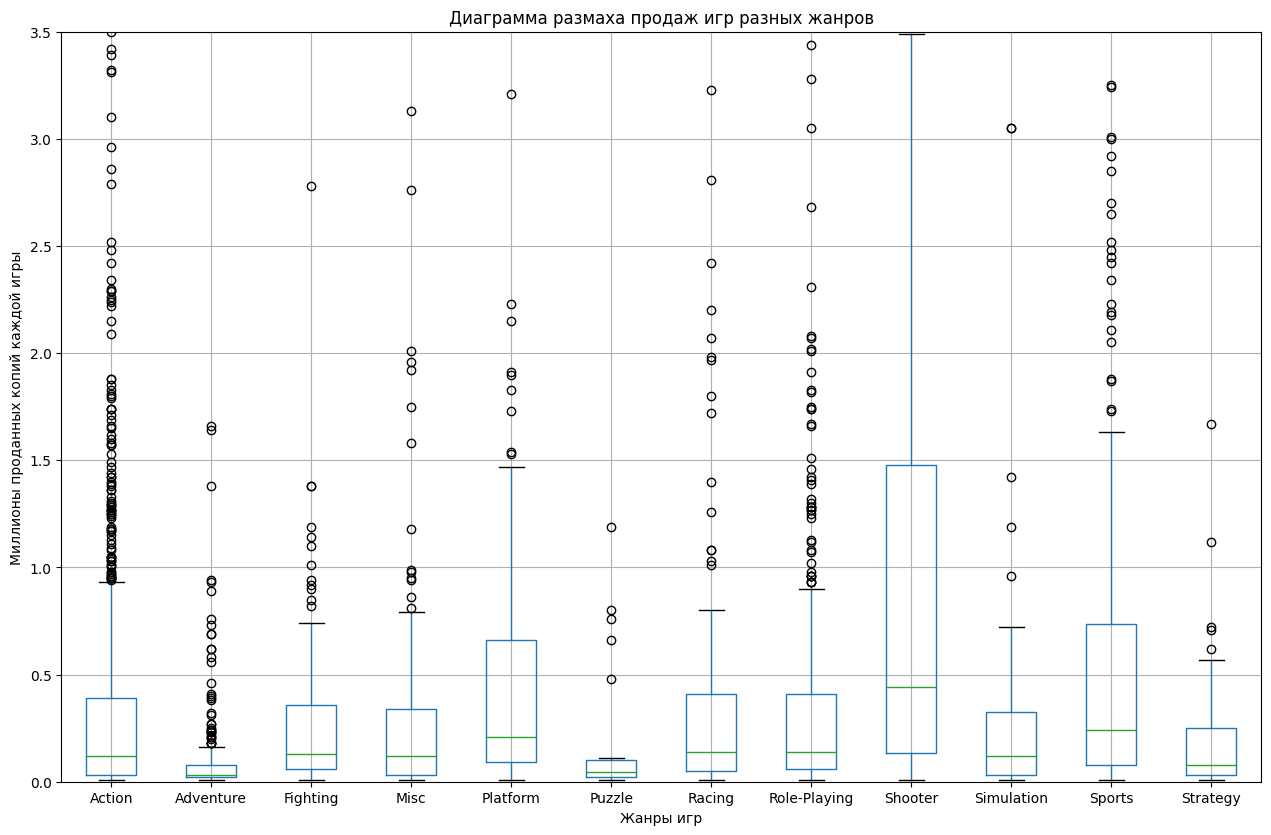

In [28]:
data.boxplot(column=['sum_sales'], by='genre', figsize=(15,10)) 
plt.suptitle('')
plt.title('Диаграмма размаха продаж игр разных жанров')
plt.xlabel('Жанры игр')
plt.ylabel('Миллионы проданных копий каждой игры')
plt.ylim(0, 3.5)
plt.show()

***Изучены выпущенные и проданные игры для разных платформ в разные годы, выделены лидирующие по суммарным продажам платформы, определен актуальный для проведения исследования период; Определены и исследованы актуальные лидирующие по продажам и потенциально прибыльные платформы; Определено влияния оценок критиков и пользователей на продажи игр разных платформ; определены прибыльные и популярные жанры.***

### Составление портрета пользователя каждого региона

Определим для пользователя каждого региона самые популярные платформы, для этого создадим круговую диаграмму.

В Северной Америке люди предпочитают играть на отечественной XBox 360, в Японии больше всего копий игр было продано для отечественной платформы Nintendo 3DS, а в Европе выбирают японскую PlayStation 4. 
Из всех проданных игр для PS4 в мире, 45% было продано для европейцев, 35% - для американцев, 5% - для японцев. 
Из всех проданных игр для 3DS в мире, 22% было продано для европейцев, 28% - для американцев, 45% - для японцев.
Из всех проданных игр для X360 в мире, 31% было продано для европейцев, 59% - для американцев, а в Японии эта платформа даже не вошла в топ-5.

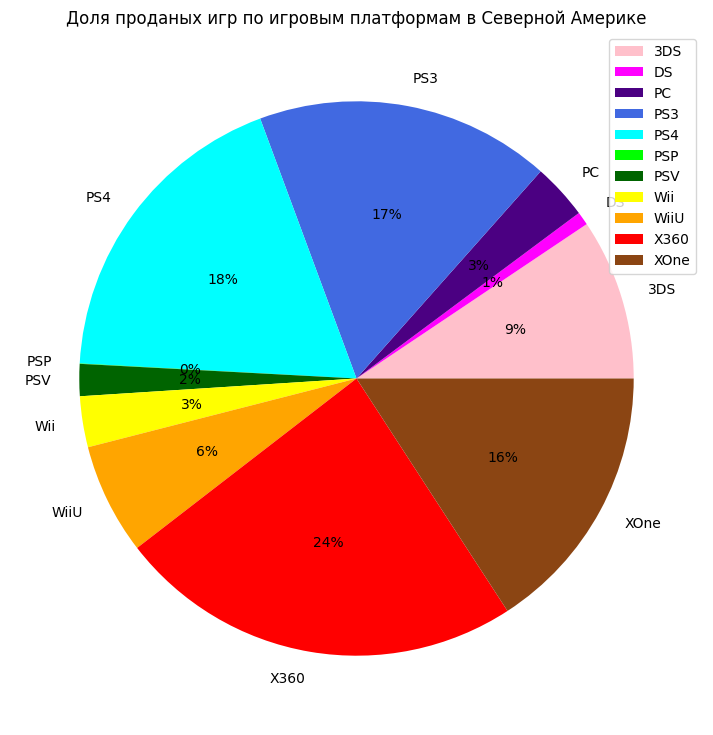

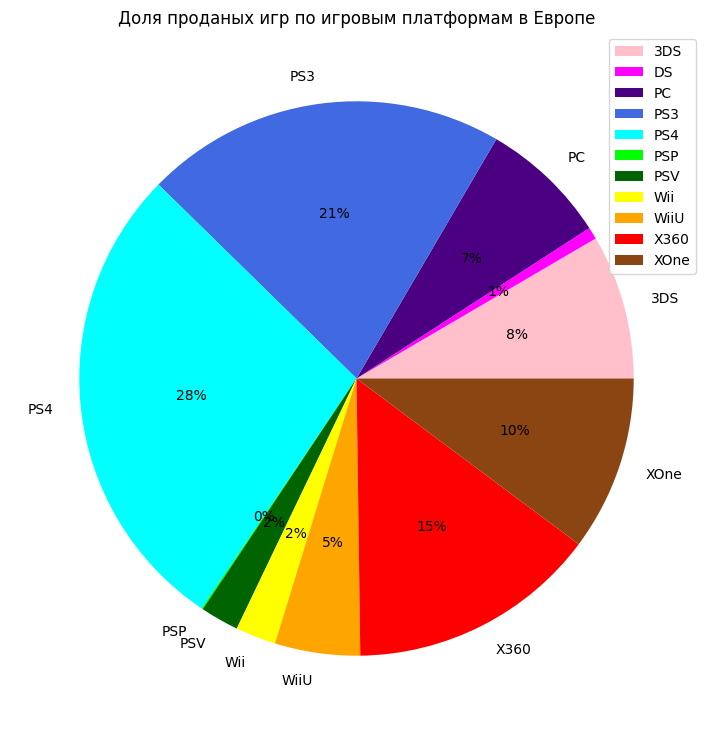

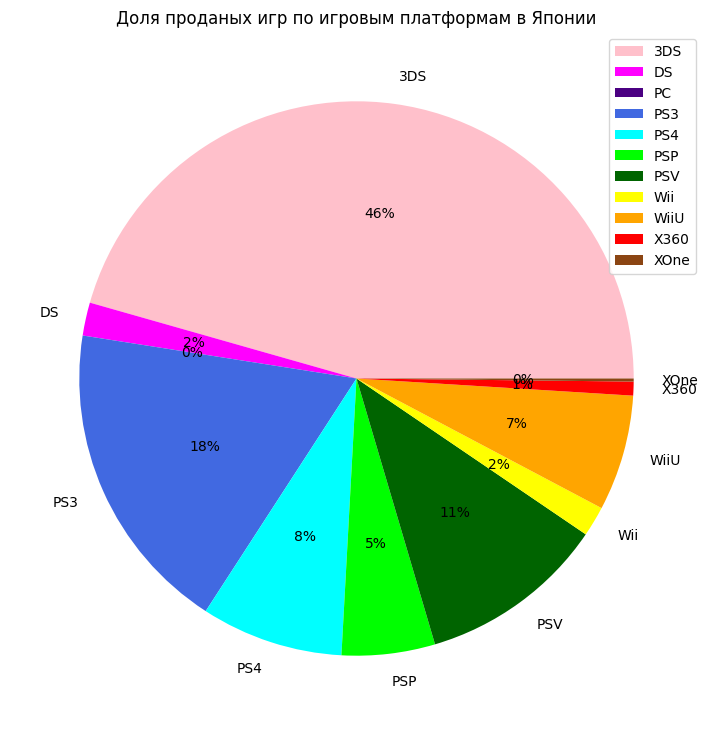

In [29]:
colors = ['pink', 'fuchsia', 'indigo', 'royalblue', 'cyan', 'lime', 'darkgreen', 'yellow', 'orange', 'red', 'saddlebrown'] 
dt_platform = data.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

dt_platform.plot(y='na_sales', kind='pie', figsize=(9, 9), autopct='%1.0f%%', colors=colors)
plt.title("Доля проданых игр по игровым платформам в Северной Америке")
plt.ylabel("")

dt_platform.plot(y='eu_sales', kind='pie', figsize=(9, 9), autopct='%1.0f%%', colors=colors)
plt.title("Доля проданых игр по игровым платформам в Европе")
plt.ylabel("")

dt_platform.plot(y='jp_sales', kind='pie', figsize=(9, 9), autopct='%1.0f%%', colors=colors)
plt.title("Доля проданых игр по игровым платформам в Японии")
plt.ylabel("")
plt.show()

Определим для пользователя каждого региона самые популярные жанры, для этого построим сводную таблицу.

В Европе и в Северной Америке лучше продаются экшены, шутеры, спортивные симуляторы и ролевые игры. В Японии топ отличается - там больше всего любят ролевые игры, затем идут экшены и прочие жанры.

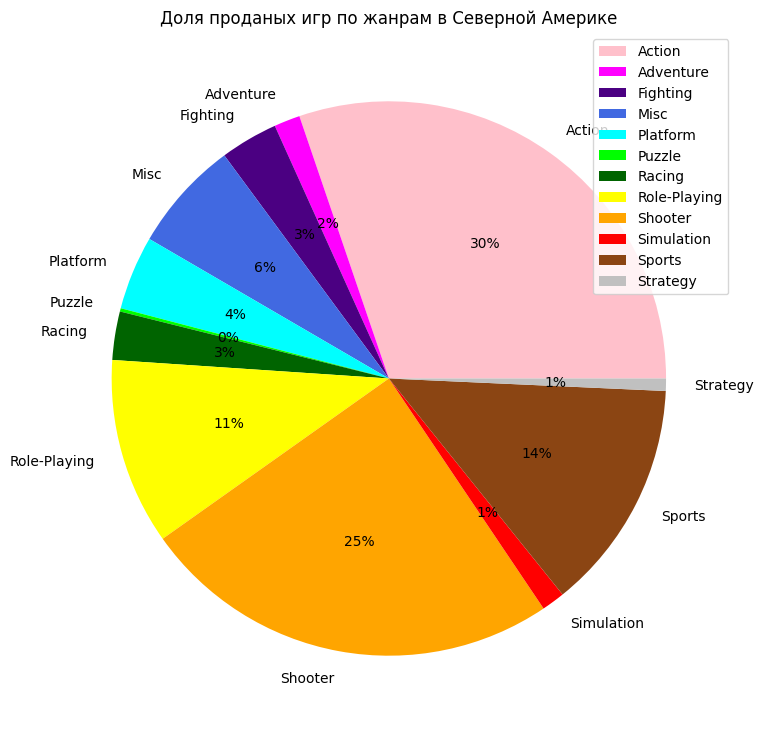

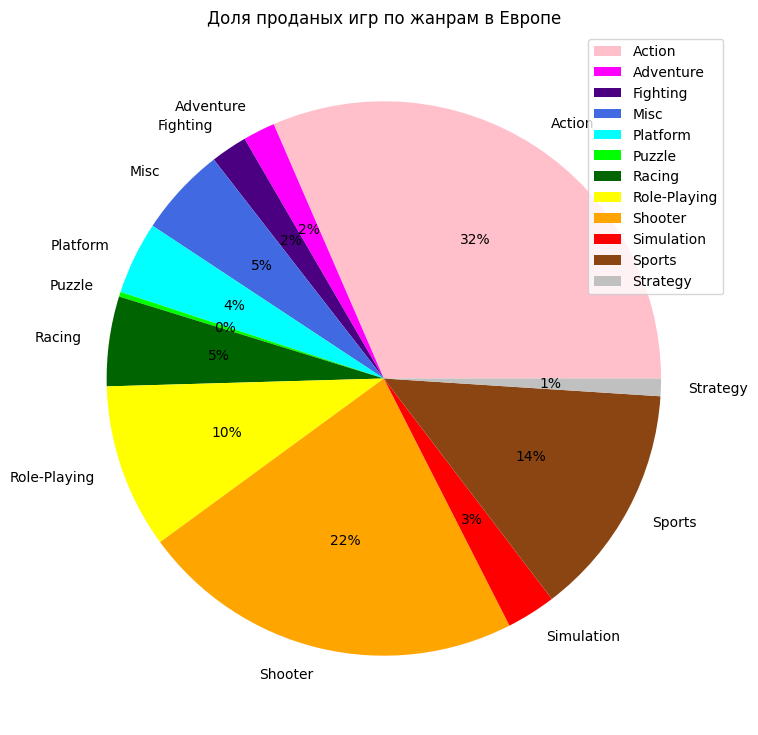

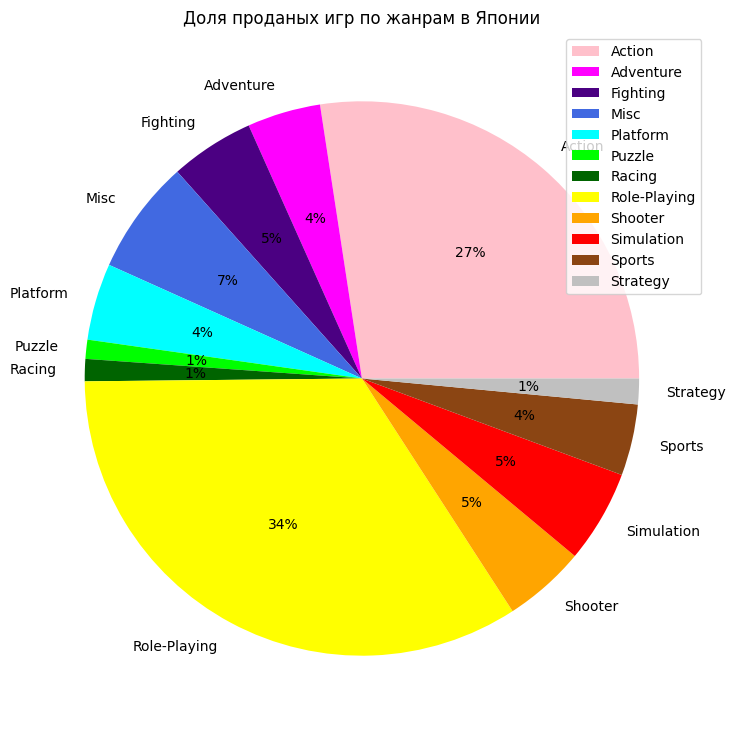

In [30]:
colors2 = ['pink', 'fuchsia', 'indigo', 'royalblue', 'cyan', 'lime', 'darkgreen', 'yellow', 'orange', 'red', 'saddlebrown', 'silver'] 
dt_genre = data.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

dt_genre.plot(y='na_sales', kind='pie', figsize=(9, 9), autopct='%1.0f%%', colors=colors2)
plt.title("Доля проданых игр по жанрам в Северной Америке")
plt.ylabel("")

dt_genre.plot(y='eu_sales', kind='pie', figsize=(9, 9), autopct='%1.0f%%', colors=colors2)
plt.title("Доля проданых игр по жанрам в Европе")
plt.ylabel("")

dt_genre.plot(y='jp_sales', kind='pie', figsize=(9, 9), autopct='%1.0f%%', colors=colors2)
plt.title("Доля проданых игр по жанрам в Японии")
plt.ylabel("")
plt.show()

Определим, влияет ли рейтинг ESRB на продажи в отдельном регионе, для этого построим сводную таблицу и столбчатую диаграмму. 

В Японии возрастной рейтинг часто не указан(RP2 здесь значит "rating pending 2" - рейтинг ожидается). Продается много игр с рейтингом teen и everyone, меньше mature и совсем мало everyone ten plus. 
В Европе и Северной Америке хорошо продаются игры с рейтингом mature, хуже с рейтингом everyone, игр с возрастным рейтингом teen и everyone ten plus было продано еще меньше.
Скорее всего сам по себе рейтинг не сильно влияет на продажи, скорее то, какого жанра игры продаются лучше - влияет на рейтинг. Например в Европе И Северной Америке популярны шутеры, этот жанр часто предполагает рейтинг mature, а значит игры с таким рейтингом продаются лучше в этих регионах.

,eu_sales,jp_sales,na_sales
age_rating,,,
E,112.80,28.33,112.26
E10+,55.37,8.19,75.70
M,193.96,21.20,231.57
RP2,91.50,108.84,103.31
T,52.12,26.01,65.40


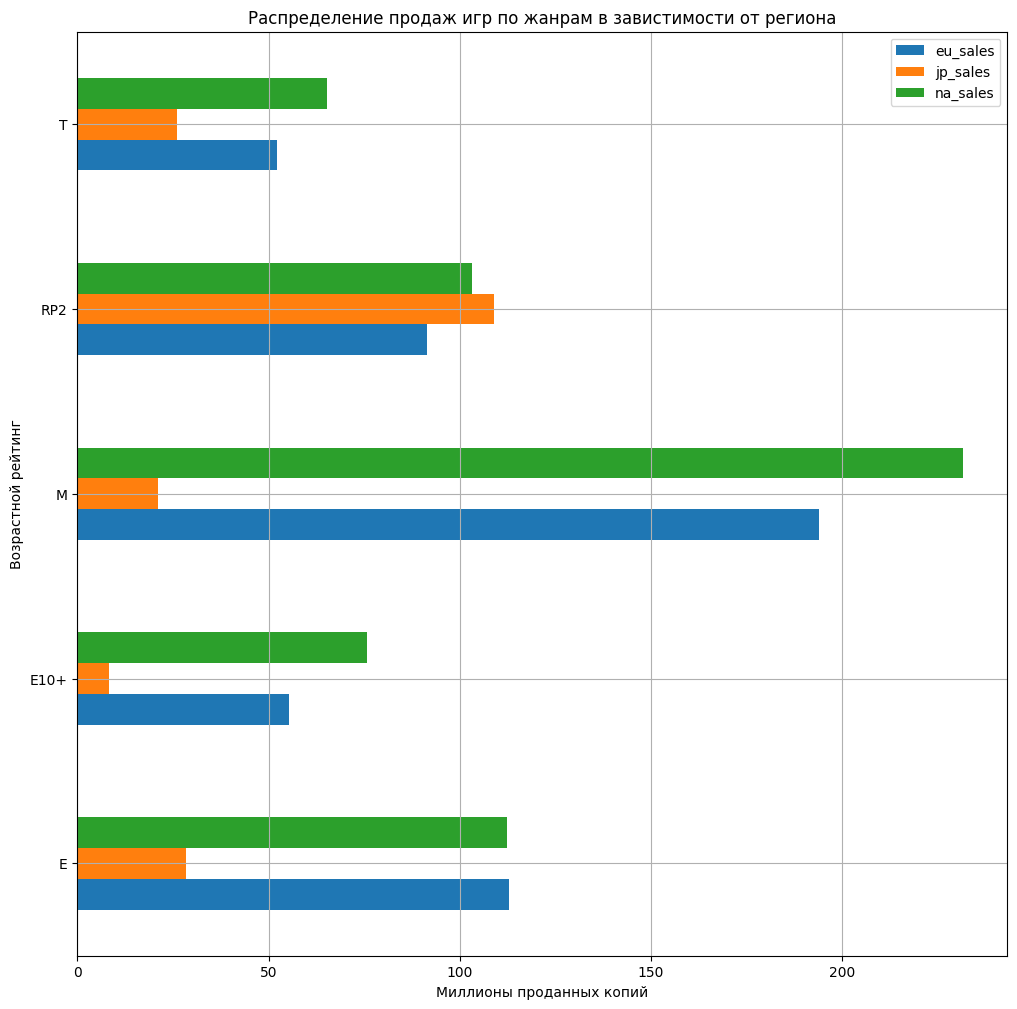

In [31]:
dt_age_rating = data.pivot_table(index='age_rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
dt_age_rating.plot(kind='barh', figsize=(12,12), grid=True)
plt.title('Распределение продаж игр по жанрам в завистимости от региона')
plt.xlabel('Миллионы проданных копий')
plt.ylabel('Возрастной рейтинг')
dt_age_rating

***Для пользователя каждого региона определены самые популярные платформы и самые популярные жанры, изучено влияние рейтинга ESRB на продажи в разных регионах.***


### Проверка гипотез

Проверим гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Зададим уровень значимости 0.05, параметр equal_var=False потому, что выборки разного размера.

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC разные.

*На имеющихся данных(полученное значение p-value = ~0.506590), на уровне значимости 5% нет оснований отвергать нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) платформ Xbox One и PC.*

In [32]:
xboxone_user_rating = data.query('platform=="XOne" and user_score!=-2')['user_score']
pc_user_rating = data.query('platform=="PC" and user_score!=-2')['user_score']
print(f'Размер выборки оценок пользователей Xbox One: {len(xboxone_user_rating)}')
print(f'Размер выборки оценок пользователей PC: {len(pc_user_rating)}\n')
print(f'Средний рейтинг пользователей Xbox One: {xboxone_user_rating.mean()}')
print(f'Средний рейтинг пользователей PC: {pc_user_rating.mean()}\n')

alpha = 0.05

results = st.ttest_ind(xboxone_user_rating, pc_user_rating, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Размер выборки оценок пользователей Xbox One: 182
Размер выборки оценок пользователей PC: 205

Средний рейтинг пользователей Xbox One: 6.521428571428572
Средний рейтинг пользователей PC: 6.418536585365853

p-значение: 0.5065901030514672
Не получилось отвергнуть нулевую гипотезу


Проверим гипотезу, что средние пользовательские рейтинги жанров Action и Sports разные. Зададим уровень значимости 0.05, параметр equal_var=False потому, что выборки разного размера.

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports одинаковые.

Альтернативная гипотеза: средние пользовательские рейтинги пжанров Action и Sports разные.

*На имеющихся данных(полученное значение p-value = ~8.449849e-20), на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы - средние пользовательские рейтинги жанров Action и Sports разные.*

In [33]:
action_user_rating = data.query('genre=="Action" and user_score!=-2')['user_score']
sports_user_rating = data.query('genre=="Sports" and user_score!=-2')['user_score']
print(f'Размер выборки оценок игроков жанра Action: {len(action_user_rating)}')
print(f'Размер выборки оценок игроков жанра Sports: {len(sports_user_rating)} \n')
print(f'Средний пользовательский рейтинг жанра Action: {action_user_rating.mean()}')
print(f'Средний пользовательский рейтинг жанра Sports: {sports_user_rating.mean() } \n')

alpha = 0.05

results = st.ttest_ind(action_user_rating, sports_user_rating, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Размер выборки оценок игроков жанра Action: 523
Размер выборки оценок игроков жанра Sports: 193 

Средний пользовательский рейтинг жанра Action: 6.825047801147227
Средний пользовательский рейтинг жанра Sports: 5.455440414507772 

p-значение: 8.449849446620474e-20
Отвергаем нулевую гипотезу


Сформулировал нулевые гипотезы исходя из принципа, что их часто формулируют так, чтобы использовать знак равенства. Это полезно, чтобы зафиксировать параметр генеральной совокупности и построить распределение.
В дополнение к ним сформулировал альтернативные гипотезы. В данных случаях, альтернативные гипотезы двусторонние, потому что они предполагают возможное отклонение и в большую, и в меньшую стороны.

Для проверки гипотез применил t-критерий Стьюдента, он подходит для проверки нулевых гипотез о
равенстве истинных средних двух генеральных совокупностей друг другу.

***Проверены гипотезы о равенстве средних пользовательских рейтингов платформ Xbox One и PC и о разности средних пользовательских рейтингов жанров Action и Sports.***

### Общий вывод

Целью проекта было выявить определяющие успешность игры закономерности. Это позволило бы интернет-магазину «Стримчик» сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Изначально были доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и игровые платформы.

Первым шагом проекта была подготовка данных. Названия столбцов были приведены к змеиному_регистру. Удалось полностью избавиться от пропусков - были обработаны пропуски в шести стобцах - кое-где строки пришлось удалить, где-то отсутствующие значения я заменил медианой, где-то присвоил ему -1 или -2, в одном столбце создал новую категорию и присвоил ее всем ячекам с пропусками. Измененены типы данных на более соответствующие. Обработаны дубликаты. Добавлен необходимый для исследования столбец. В результате подготовки данных удалось сохранить большинство строк.

Вторым шагом стало проведение исследовательского анализа данных. Были изучены выпущенные и проданные игры для разных платформ в разные годы, это позволило определить актуальный для проведения исследования период. Я решил что это будут последние 5 лет - в каждый год из них было продано около 600 игр, к тому же 5 лет составляют половину среднего срока актуальности платформ. Затем были определены и исследованы лидирующие по продажам в последнее время и потенциально прибыльные платформы. Оказалось, что продажи игр среди всех актуальных платформ падают. Относительно остальных, прибыльными все еще оставались PS4 - более 69 миллионов проданных копий игр за последние 5 лет, XOne - более 26 миллионов и 3DS - более 15 миллионов проданных копий игр. Было выяснено, что , у каждой потенциально прибыльных платформ есть игры-хиты, сильно оторвавшиеся по продажам от остальных. Большинство же игр покупали не более 2 миллионов раз. Была определена степень влияния оценок критиков и пользователей на продажи игр разных платформ. Оказалось, что на успешность игр никак не влияют оценки пользователей, например у PS4 коэффициент корреляции -0.03, возможно это связано с тем, что оценки пользователей необъективны. Отзывы критиков умеренно влияют на число проданных копий, у той же PS4 коэффициент корреляции составил 0.41. Обнаружилась заметная связь между оценками критиков и оценками пользователей, коэффициент корреляции для PS4 - 0.56. Были определены прибыльные и популярные жанры. Самым популярным жанром оказался экшен - в нем выпущенно более 1000 игр за последние 5 лет и проданно более 400 миллионов копий. Самыми прибыльными могут быть шутер, ролевая игра, спорт, экшен.

Следующим шагом было составление портрета пользователя каждого региона. В Северной Америке люди предпочитали играть на XBox 360, в Японии больше копий игр было продано для Nintendo 3DS, а в Европе выбирали PlayStation 4. Из всех проданных игр для PS4 в мире, 45% было продано для европейцев, 35% - для американцев, 5% - для японцев. Из всех проданных игр для 3DS в мире, 22% было продано для европейцев, 28% - для американцев, 45% - для японцев. Из всех проданных игр для X360 в мире, 31% было продано для европейцев, 59% - для американцев, а в Японии эта платформа даже не вошла в топ-5. В Европе и в Северной Америке лучше продавались экшены, шутеры, спортивные симуляторы и ролевые игры. В Японии топ отличается - там больше всего любили ролевые игры, затем шли экшены и прочие жанры. Был сделан вывод, что сам по себе рейтинг не сильно влияет на продажи, скорее то, какого жанра игры продаются лучше - влияет на рейтинг. Например в Европе И Северной Америке популярны шутеры, этот жанр часто предполагает рейтинг mature, а значит игры с таким рейтингом продаются лучше в этих регионах.

Последним шагом была проверка гипотез, в результате ее выполнения был сделан вывод, что есть основания считать, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Сделан вывод, что есть основания считать, что средние пользовательские рейтинги жанров Action и Sports разные.

Исходя из проведенных исследований я предлагаю для Северной Америки делать ставку на игры для XBox 360, предпочтительные жанры - шутеры, спортивные симуляторы и ролевые игры. Для европы желательно выбирать игры на платформе PlayStation 4, жанры - как у Северной Америки - шутер, спорт, ролевые игры.  Для Японии рекомендую присмотреться к играм на Nintendo 3DS в жанре рол плей.
Для всех регионов актуально делать ставку на жанр экшен, если игра от известного разработчика, и на ее разработку потрачен большой бюджет. Следует прислушиваться к мнению критиков, можно не обращать внимания на отзывы игроков.